In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
#!pip install prophet

In [5]:
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


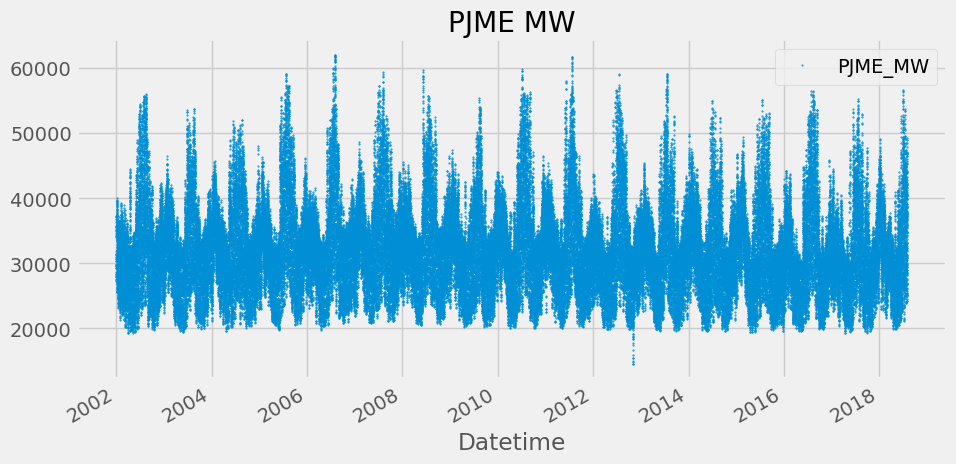

In [6]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Time Series Features

In [7]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [8]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


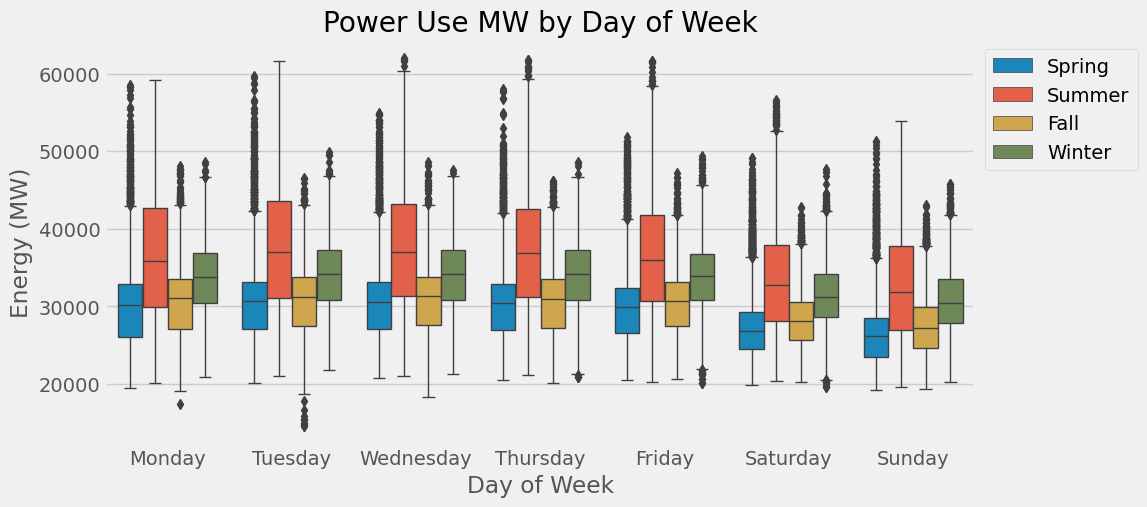

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

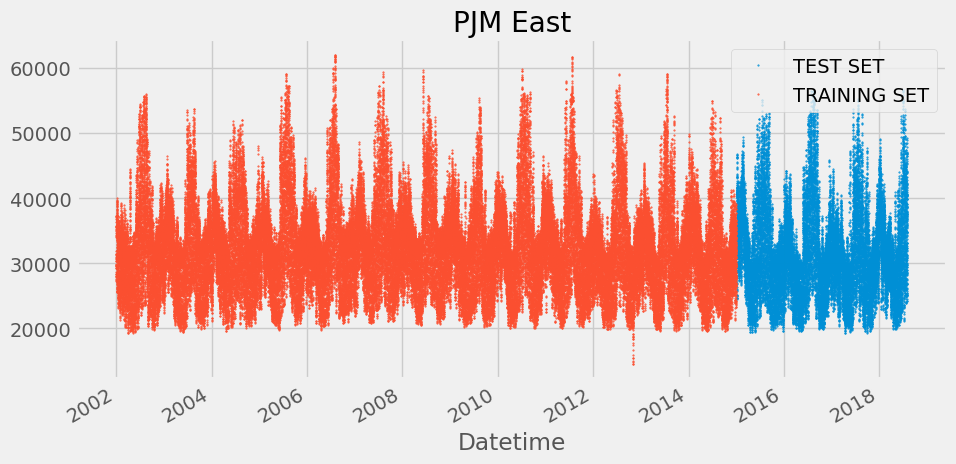

In [10]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
<li>Datetime column named: ds</li>
<li>target : y</li>

In [11]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [12]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:48:21 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 11.8 s, sys: 812 ms, total: 12.6 s
Wall time: 2min 31s


In [13]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [14]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31219.153598,23897.862611,32812.280440,31219.153598,31219.153598,-2840.510608,-2840.510608,-2840.510608,-4430.339743,...,1281.410846,1281.410846,1281.410846,308.418289,308.418289,308.418289,0.0,0.0,0.0,28378.642991
1,2015-01-01 02:00:00,31219.117029,22454.192918,31375.671042,31219.117029,31219.117029,-4344.847334,-4344.847334,-4344.847334,-5927.236245,...,1272.652594,1272.652594,1272.652594,309.736317,309.736317,309.736317,0.0,0.0,0.0,26874.269694
2,2015-01-01 03:00:00,31219.080459,21672.376983,30387.890358,31219.080459,31219.080459,-5216.524042,-5216.524042,-5216.524042,-6790.308573,...,1262.688688,1262.688688,1262.688688,311.095842,311.095842,311.095842,0.0,0.0,0.0,26002.556417
3,2015-01-01 04:00:00,31219.043890,21393.504768,30457.934378,31219.043890,31219.043890,-5358.072919,-5358.072919,-5358.072919,-6922.212522,...,1251.642711,1251.642711,1251.642711,312.496892,312.496892,312.496892,0.0,0.0,0.0,25860.970971
4,2015-01-01 05:00:00,31219.007320,21762.444746,30863.713019,31219.007320,31219.007320,-4683.736623,-4683.736623,-4683.736623,-6237.326567,...,1239.650454,1239.650454,1239.650454,313.939491,313.939491,313.939491,0.0,0.0,0.0,26535.270698


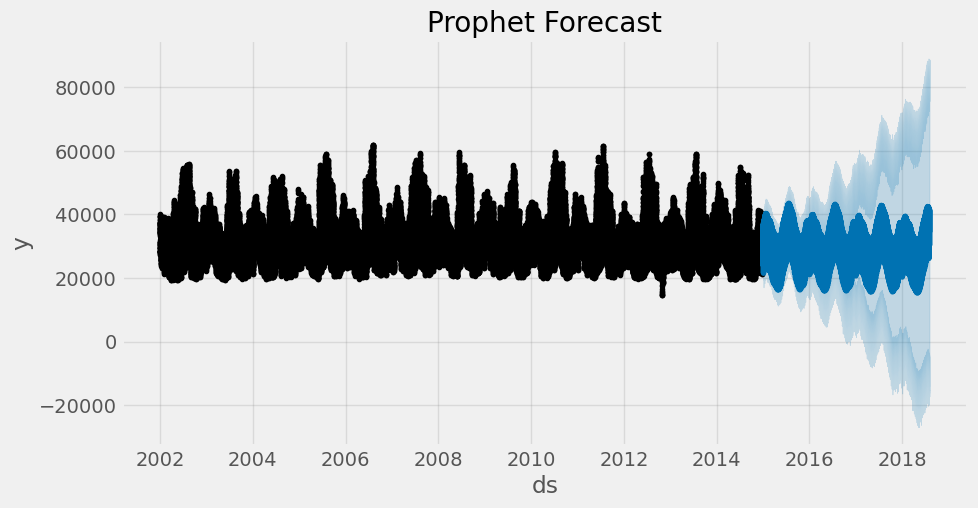

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

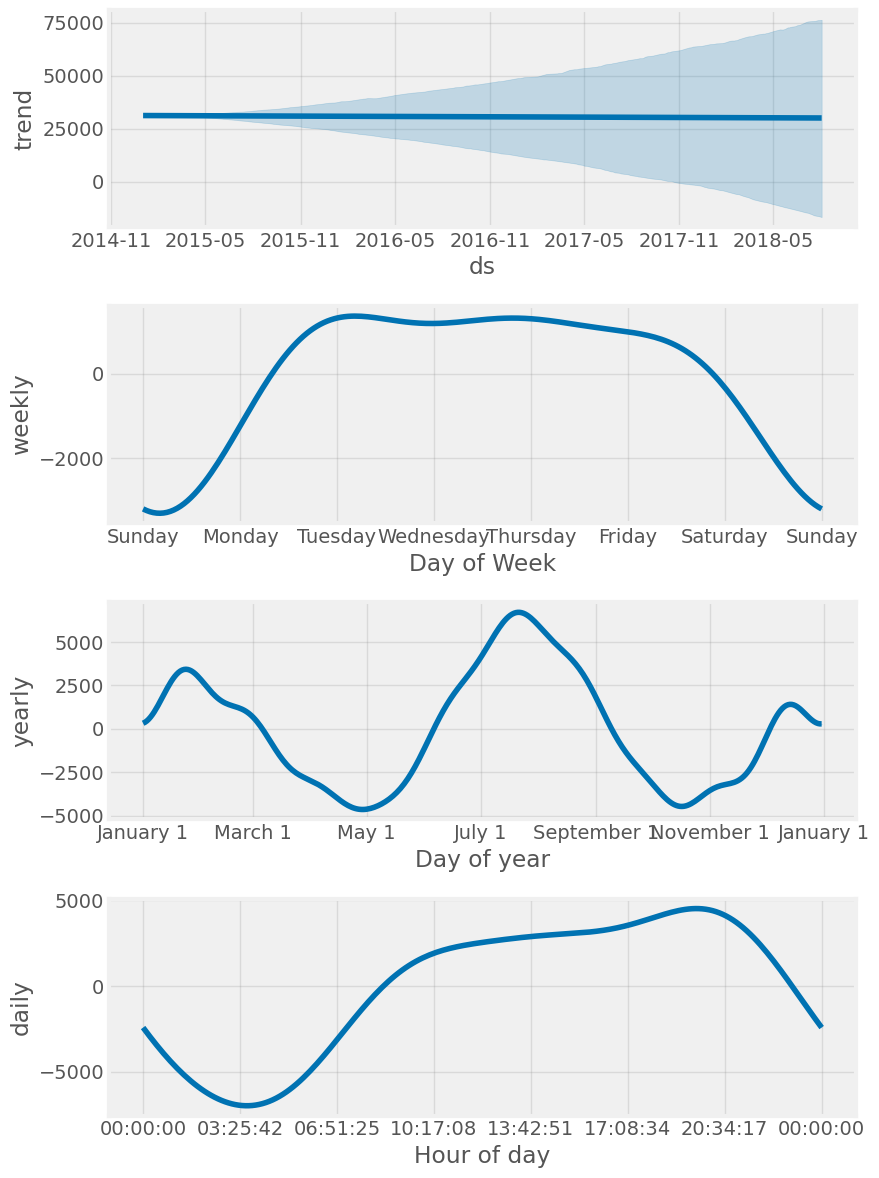

In [16]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

<h3>Compare Forecast to Actuals</h3>

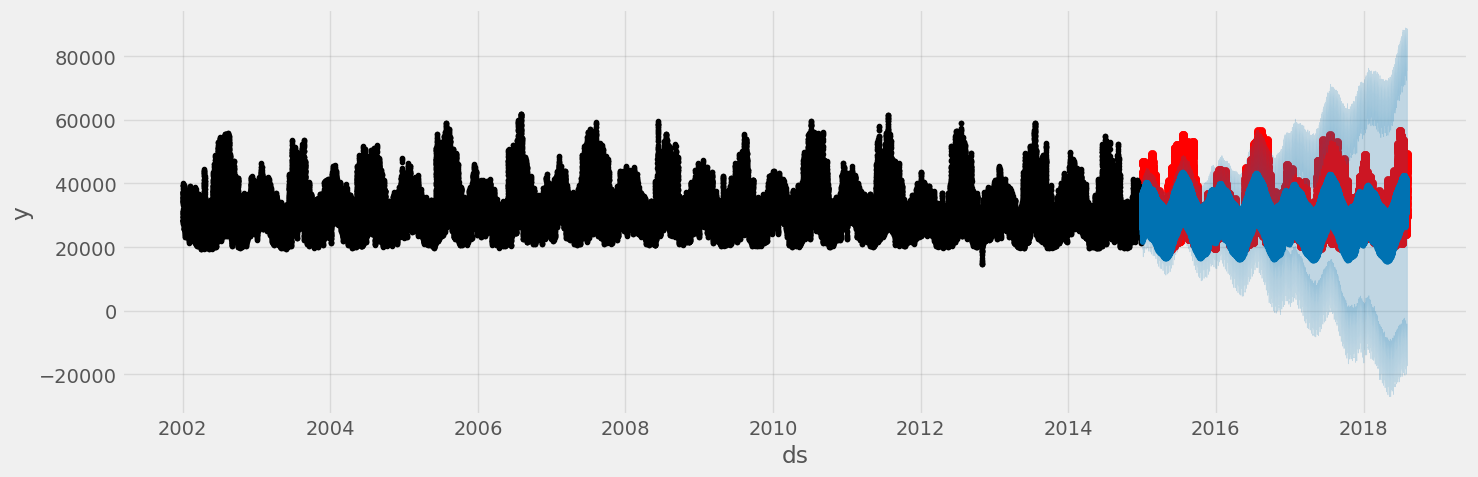

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

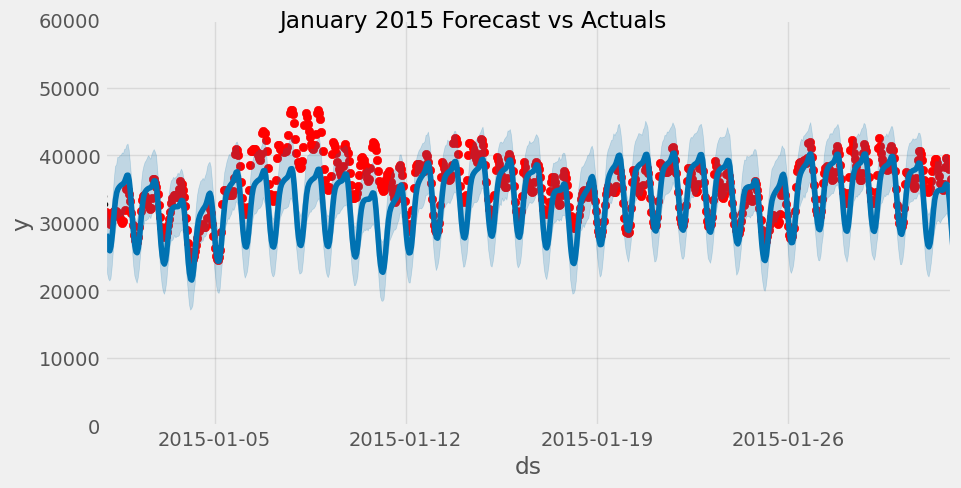

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

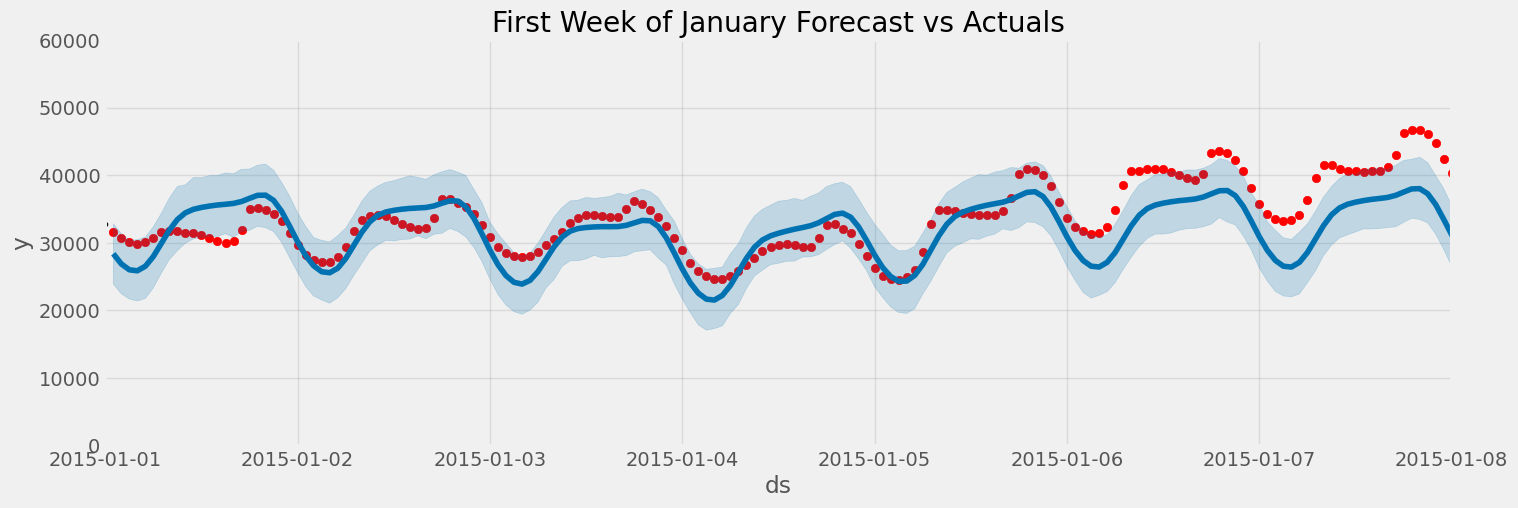

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

<h3>Evaluate the model with Error Metrics</h3>

In [20]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6613.501790535714

In [21]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.270604214821

In [22]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512656656397837

<h3>Adding Holidays</h3>
<p>Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.</p>

<p>We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays</p>

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [26]:
holiday_df.head()

,ds,holiday
0,2002-01-21,Martin Luther King Jr. Day
1,2002-02-18,Presidents Day
2,2002-05-27,Memorial Day
3,2002-07-04,July 4th
4,2002-09-02,Labor Day


In [24]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

09:39:12 - cmdstanpy - INFO - Chain [1] start processing
09:42:10 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 13.4 s, sys: 1.14 s, total: 14.5 s
Wall time: 3min 12s


In [25]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

In [ ]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

# Predict into the Future

In [27]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [30]:
future.head()

,ds
0,2015-01-01 01:00:00
1,2015-01-01 02:00:00
2,2015-01-01 03:00:00
3,2015-01-01 04:00:00
4,2015-01-01 05:00:00


In [28]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25543.650282
1,2015-01-01 02:00:00,24041.687119
2,2015-01-01 03:00:00,23172.114677
3,2015-01-01 04:00:00,23032.444004
4,2015-01-01 05:00:00,23708.374919
